## Description

The objective of this project is to test different architectures to compare two digits visible in a two-channel image. It aims at showing in particular the impact of weight sharing, and of the use of an auxiliary loss to help the training of the main objective. 
It should be implemented with PyTorch only code, in particular without using other external libraries such as scikit-learn or numpy.

The goal of this project is to implement a deep network such that, given as input a series of 2×14×14
tensor, corresponding to pairs of 14 × 14 grayscale images, it predicts for each pair if the first digit is
lesser or equal to the second.

In [87]:
import matplotlib.pyplot as plt
import numpy as np # For easy mean of accuracy calculating
import pandas as pd # To create table with comparison of different version of models

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import copy

from networks import NetSimple, NetSiamese
from utils import get_accuracy, grid_search, plot_accuracy_and_loss, test_samples, test_model, plot_test_results

from dlc_practical_prologue import generate_pair_sets

## Data

The training and test set should be 1, 000 pairs each, and the size of the images allows to run
experiments rapidly, even in the VM with a single core and no GPU.
You can generate the data sets to use with the function generate_pair_sets(N) defined in the file
dlc_practical_prologue.py.

In [2]:
N = 1000

In [3]:
train_input, train_class, train_digit, test_input, test_class, test_digit = generate_pair_sets(N)

Let's first normalise data for faster convergence of model

In [4]:
mean = torch.mean(train_input)
std = torch.std(train_input)
train_input = (train_input - mean) / std
test_input = (test_input - mean) / std

torch.mean(train_input), torch.std(train_input), torch.mean(test_input), torch.std(test_input)

(tensor(-4.7528e-08), tensor(1.), tensor(0.0059), tensor(1.0081))

Let's plot what the data is: images, class and digit values. 

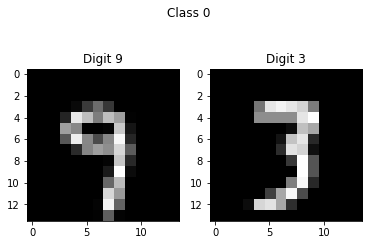

In [5]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(train_input[0][0], cmap="gray")
axs[0].set_title(f"Digit {train_digit[0][0].item()}")
axs[1].imshow(train_input[0][1], cmap="gray")
axs[1].set_title(f"Digit {train_digit[0][1].item()}")
fig.suptitle(f"Class {train_class[0].item()}")

plt.show()

---

Let's check wheither our classes are balanced.

In [6]:
from collections import Counter

In [7]:
count_train = Counter([el.item() for el in train_class])
count_train

Counter({0: 449, 1: 551})

We see that classes are not balanced. This can lead to bias in network. There are two simple ways to do that:
* Deleting some of instances of dominating class from dataset. Cons of this procedure is that we are literally decreasing size of our dataset. However, in current situation difference in class sizes is not that big. 
* Increasing number of instances of minor class by simple copying some of already existing instances. Cons of this approach is that it may lead to overfitting, since net will see some of inctances more often that another ones. 

In [8]:
def balance_data_classes(train_input, train_class, train_digit, mode="oversampling"):
    """Balances data by over or under sampling"""
    count_train = Counter([el.item() for el in train_class])
    diff = count_train[1] - count_train[0]
    if diff == 0: # No balancing needed
        return train_input, train_class, train_digit
    
    major_class, minor_class = (1, 0) if diff > 0 else (0, 1)
    major_class_indices = [ind for ind in range(len(train_class)) if train_class[ind].item() == major_class]
    minor_class_indices = [ind for ind in range(len(train_class)) if train_class[ind].item() == minor_class]
    
    # Build new indices
    if mode == "oversampling":
        perm = torch.randperm(len(minor_class_indices))[:diff]
        indices_to_add = [minor_class_indices[ind] for ind in perm]
        minor_class_indices += indices_to_add # Adding random instances
    elif mode == "undersampling":
        major_class_indices = major_class_indices[:-diff] # Deleting some of instances
    else:
        raise NotImplementedError
    
    # Concatenate and permute indices
    new_data_indices = major_class_indices + minor_class_indices
    perm = torch.randperm(len(new_data_indices))
    new_data_indices = [new_data_indices[ind] for ind in perm]
    
    # Build new data
    train_input = train_input[new_data_indices]
    train_class = train_class[new_data_indices]
    train_digit = train_digit[new_data_indices]
    return train_input, train_class, train_digit

In [9]:
train_input, train_class, train_digit = balance_data_classes(train_input, train_class, train_digit, mode="oversampling")

Let's check wheither it worked in a way we wanted

In [10]:
count_train = Counter([el.item() for el in train_class])
count_train

Counter({0: 551, 1: 551})

Here is our final data preprocessing pipeline: 

In [11]:
def get_data_generator(mode=None):
    
    def generate_data(N=1000, mode=mode):
        """Generates pair datasets and returns them as DataLoader classes"""
        train_input, train_class, train_digit, test_input, test_class, test_digit = generate_pair_sets(N)
        
        # Normalising data
        mean = torch.mean(train_input)
        std = torch.std(train_input)
        train_input = (train_input - mean) / std
        test_input = (test_input - mean) / std

        # Balancing data
        if mode:
            train_input, train_class, train_digit = balance_data_classes(train_input, train_class, train_digit, mode)

        train_loader = DataLoader(list(zip(train_input, train_class, train_digit)), batch_size=64)
        test_loader = DataLoader(list(zip(test_input, test_class, test_digit)), batch_size=64)
        return train_loader, test_loader
    
    return generate_data

In [12]:
generate_data = get_data_generator(mode=None) # Not applying over or under sampling technique
train_loader, test_loader = generate_data()

## Objective

The goal of the project is to compare different architectures, and assess the performance improvement
that can be achieved through weight sharing, or using auxiliary losses. For the latter, the training can
in particular take advantage of the availability of the classes of the two digits in each pair, beside the
Boolean value truly of interest.

In [13]:
cross_entropy = nn.CrossEntropyLoss()
binary_cross_entropy = nn.BCEWithLogitsLoss()

## Model

In [14]:
# Task specific setup
input_channels = 2
output_class_channels = 2 # Each represents probability of corresponding class
output_digit_channels = 10 # Each represents probability of corresponding digit

### Simple model

First let's implement simple model. It;s architecture is based on (LeNet)[] and adapted for current task by adding dropout layers and adjusting filters and neurons number.

In [15]:
net = NetSimple(input_channels, output_class_channels)

In [16]:
def simple_model_criterion(output, target):
    """Loss criterion for simple model: binary cross entropy for class predictons"""
#     return binary_cross_entropy(output, target.unsqueeze(1).float()) # Case of 1 output neuron
#     print(output, target)
    return cross_entropy(output, target)

In [17]:
from torchsummary import summary
summary(net, input_size=(2, 14, 14), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 12, 12]             304
            Conv2d-2           [-1, 32, 10, 10]           4,640
         MaxPool2d-3             [-1, 32, 5, 5]               0
           Dropout-4                  [-1, 800]               0
            Linear-5                   [-1, 50]          40,050
           Dropout-6                   [-1, 50]               0
            Linear-7                    [-1, 2]             102
Total params: 45,096
Trainable params: 45,096
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.17
Estimated Total Size (MB): 0.23
----------------------------------------------------------------


### Model with weight sharing

Since we know that in both channels we have digits, its logical to process them in same way. For that we will use same convolution and fully connected layers. At the end we will also add 2 fully connected layers to actually solve our general task of class prediction.

In [18]:
net = NetSiamese(input_channels, output_class_channels, output_digit_channels)

In [19]:
from torchsummary import summary
summary(net, input_size=(2, 14, 14), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 12, 12]             160
            Conv2d-2           [-1, 32, 10, 10]           4,640
         MaxPool2d-3             [-1, 32, 5, 5]               0
            Conv2d-4           [-1, 16, 12, 12]             160
            Conv2d-5           [-1, 32, 10, 10]           4,640
         MaxPool2d-6             [-1, 32, 5, 5]               0
           Dropout-7                  [-1, 800]               0
            Linear-8                   [-1, 50]          40,050
           Dropout-9                   [-1, 50]               0
           Linear-10                   [-1, 10]             510
          Dropout-11                  [-1, 800]               0
           Linear-12                   [-1, 50]          40,050
          Dropout-13                   [-1, 50]               0
           Linear-14                   

In [20]:
def siamese_model_criterion(output, target):
    """Loss criterion for siamese model: binary cross entropy for class predictons"""
#     return binary_cross_entropy(output, target.unsqueeze(1).float()) # Case of 1 output neuron
    return cross_entropy(output, target)

One positive side effect of weight sharing in current setup will be that model will have double more data to train first layers. It happens because we divided each sample in our data and obtained twice more samples.

### Siamese model with auxiliary loss

We implemented 3 different version of siamese network which differ in a way of processing results of two subnetworks

In [21]:
siamese_net_versions = NetSiamese.possible_version[:3]  # Taking basic versions

In these model we will try to train model to not only predict class but also both digits. For that we will use Siamese network from previous step but also add addtional losses on intermediate fully connected layers

In [22]:
def get_auxiliary_loss_model_criterion(lambda_=1):
    
    def auxiliary_loss_model_criterion(output_class, target_class, output_digits, target_digits):
        """Loss criterion for siamese model with auxiliary loss: 
        binary cross entropy for class predictons, cross entropy for both digit predictions"""
        # Case of 1 output neuron
#         return lambda_ * binary_cross_entropy(output_class, target_class.unsqueeze(1).float()) \
#                 + cross_entropy(output_digits[0], target_digits[:, 0]) \
#                 + cross_entropy(output_digits[1], target_digits[:, 1])

        return lambda_ * cross_entropy(output_class, target_class) \
                + cross_entropy(output_digits[0], target_digits[:, 0]) \
                + cross_entropy(output_digits[1], target_digits[:, 1])


    return auxiliary_loss_model_criterion

### Model for digit preditction

Finnaly, we will make modification of siamese network with auxiliary loss in which we will only aim at predicting both digits (This architecture will be called siamese net version 4). Decision about class assignment will be simply done by answering on question *predicted_digit1* <= *predicted_digit2*. In this setting we will remove case when we predict digits correctly but then do mistake when do class prediction. It will make for us easier to analyse model perfomance, in particular to detect overfitting in the last layers of network which are precisely responsible for class inferring. 

In [23]:
def digit_prediction_criterion(output_class, target_class, output_digits, target_digits):
    """Loss criterion for siamese model for only digit prediction: cross entropy for both digit predictions"""
    return cross_entropy(output_digits[0], target_digits[:, 0]) \
            + cross_entropy(output_digits[1], target_digits[:, 1])

## Training

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [25]:
def train(train_data_loader, test_data_loader, model, optimizer, criterion, device,
          epochs=10, early_stopping=True, print_info=False, print_every=5):
    """Trains model"""
    losses = []
    # Accuracy of class prediction
    accuracy_train_class = []
    accuracy_test_class = []
    # Accuracy of digit precition for model with auxiliary loss
    accuracy_train_digit = []
    accuracy_test_digit = []
    # Early stopping (saving the best model among epochs)
    best_model = None
    best_accuracy = 0
    
    model.to(device)
    
    for epoch in range(epochs):
        loss_epoch = 0
        
        # Train
        for (image, target_class, target_digits) in train_data_loader:
            image, target_class, target_digits = image.to(device), target_class.to(device), target_digits.to(device)
            optimizer.zero_grad()
            if model.predicts_digit: # For model with auxiliary loss
                output_class, output_digits = model(image)
                loss = criterion(output_class, target_class, output_digits, target_digits)
            else:
                output_class = model(image)
                loss = criterion(output_class, target_class)
            loss.backward()
            optimizer.step()
            
            loss_epoch += loss.item()
                
        losses.append(loss_epoch)
        
        # Test
        model.eval()
        
        with torch.no_grad():
            accuracy_train_data = get_accuracy(model, train_data_loader, device,
                                               calculate_accuracy_digit=model.predicts_digit)
            accuracy_test_data = get_accuracy(model, test_data_loader, device,
                                              calculate_accuracy_digit=model.predicts_digit)
            if model.predicts_digit: # For model with auxiliary loss
                acc_train_class, acc_train_digit = accuracy_train_data
                acc_test_class, acc_test_digit = accuracy_test_data

                accuracy_train_digit.append(acc_train_digit)
                accuracy_test_digit.append(acc_test_digit)
            else:
                acc_train_class = accuracy_train_data
                acc_test_class = accuracy_test_data

            accuracy_train_class.append(acc_train_class)
            accuracy_test_class.append(acc_test_class)
    
        if accuracy_test_class[-1] > best_accuracy:
            best_model = copy.deepcopy(model)
            best_accuracy = accuracy_test_class[-1]
            
        if print_info and (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch + 1}/{epochs}, loss {losses[-1]:0.4f},",
                  f"class train/test accuracy: {accuracy_train_class[-1]}/{accuracy_test_class[-1]}",
                  f", digit train/test accuracy: {accuracy_train_digit[-1]}/{accuracy_test_digit[-1]}"
                  if accuracy_train_digit else "")
            
    if print_info:
        print(f"Achieved accuracy: {best_accuracy}")
    
    if early_stopping:
        return best_model, [accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit], losses
    else:
        return model, [accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit], losses

#### Simple net

In [26]:
epochs_grid_search = 25
epochs_train = 30

In [27]:
lr_simple_net = 0.01
reg_simple_net = 0.25

In [28]:
model_class = NetSimple
model_params = {"input_channels": input_channels, 
                "output_channels": output_class_channels,
                "activation": "leakyrelu"}
criterion = simple_model_criterion

lr_simple_net, reg_simple_net = grid_search([0.01, 0.005, 0.001, 0.0005, 0.0001], # Learning rates
                                              [0.25, 0.1, 0.05, 0.01], # Regularizations
                                              train, train_loader, test_loader, device, 
                                              model_class, model_params, criterion, 
                                              epochs=epochs_grid_search, print_info=True)

Learning rate: 0.0100, Regularization: 0.25, Test Accuracy: 0.545
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.545
Learning rate: 0.0100, Regularization: 0.05, Test Accuracy: 0.545
Learning rate: 0.0100, Regularization: 0.01, Test Accuracy: 0.811
Learning rate: 0.0050, Regularization: 0.25, Test Accuracy: 0.545
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.563
Learning rate: 0.0050, Regularization: 0.05, Test Accuracy: 0.809
Learning rate: 0.0050, Regularization: 0.01, Test Accuracy: 0.838
Learning rate: 0.0010, Regularization: 0.25, Test Accuracy: 0.545
Learning rate: 0.0010, Regularization: 0.10, Test Accuracy: 0.768
Learning rate: 0.0010, Regularization: 0.05, Test Accuracy: 0.824
Learning rate: 0.0010, Regularization: 0.01, Test Accuracy: 0.835
Learning rate: 0.0005, Regularization: 0.25, Test Accuracy: 0.568
Learning rate: 0.0005, Regularization: 0.10, Test Accuracy: 0.771
Learning rate: 0.0005, Regularization: 0.05, Test Accuracy: 0.818
Learning r

In [29]:
net_simple = NetSimple(input_channels, output_class_channels, activation="leakyrelu")
optimizer = optim.Adam(net_simple.parameters(), lr=lr_simple_net, weight_decay=reg_simple_net)
criterion = simple_model_criterion

_, accuracies, losses = train(train_loader, test_loader,
                               net_simple,
                               optimizer, 
                               criterion,
                               device=device,
                               epochs=epochs_train, print_info=True)

accuracy_train_class, accuracy_test_class, _, _ = accuracies

Epoch 5/30, loss 7.9384, class train/test accuracy: 0.771/0.773 
Epoch 10/30, loss 6.1469, class train/test accuracy: 0.844/0.81 
Epoch 15/30, loss 4.7945, class train/test accuracy: 0.893/0.835 
Epoch 20/30, loss 3.8392, class train/test accuracy: 0.93/0.841 
Epoch 25/30, loss 2.9829, class train/test accuracy: 0.956/0.836 
Epoch 30/30, loss 2.2189, class train/test accuracy: 0.95/0.829 
Achieved accuracy: 0.845


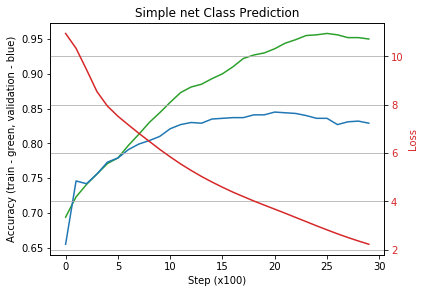

In [30]:
plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, title="Simple net Class Prediction")

In [31]:
# net_simple_filename = "net_simple.ckpt"
# torch.save(net_simple.state_dict(), net_simple_filename)

#### Siamese network

In [32]:
epochs_grid_search = 25
epochs_train = 30

In [33]:
model_class = NetSiamese
criterion = siamese_model_criterion
lr_siamese_net_all = dict()
reg_siamese_net_all = dict()

for ver in siamese_net_versions:
    print(f"Siamese net version {ver}")
    model_params = {"input_channels": input_channels, 
                    "output_class_channels": output_class_channels, 
                    "output_digit_channels": output_digit_channels,
                    "activation": "leakyrelu",
                    "version": ver}

    lr_siamese_net, reg_siamese_net = grid_search([0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], # Learning rates
                                                  [0.25, 0.1, 0.05, 0.01], # Regularizations
                                                  train, train_loader, test_loader, device, 
                                                  model_class, model_params, criterion, 
                                                  epochs=epochs_grid_search, print_info=True)
    lr_siamese_net_all[ver] = lr_siamese_net
    reg_siamese_net_all[ver] = reg_siamese_net

Siamese net version 1
Learning rate: 0.0500, Regularization: 0.25, Test Accuracy: 0.545
Learning rate: 0.0500, Regularization: 0.10, Test Accuracy: 0.545
Learning rate: 0.0500, Regularization: 0.05, Test Accuracy: 0.545
Learning rate: 0.0500, Regularization: 0.01, Test Accuracy: 0.864
Learning rate: 0.0100, Regularization: 0.25, Test Accuracy: 0.545
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.545
Learning rate: 0.0100, Regularization: 0.05, Test Accuracy: 0.853
Learning rate: 0.0100, Regularization: 0.01, Test Accuracy: 0.875
Learning rate: 0.0050, Regularization: 0.25, Test Accuracy: 0.545
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.545
Learning rate: 0.0050, Regularization: 0.05, Test Accuracy: 0.854
Learning rate: 0.0050, Regularization: 0.01, Test Accuracy: 0.860
Learning rate: 0.0010, Regularization: 0.25, Test Accuracy: 0.545
Learning rate: 0.0010, Regularization: 0.10, Test Accuracy: 0.820
Learning rate: 0.0010, Regularization: 0.05, Test Accu

Let's see the model's perfomance

Siamese net version 1
Epoch 5/30, loss 5.6837, class train/test accuracy: 0.846/0.846 
Epoch 10/30, loss 3.8586, class train/test accuracy: 0.937/0.87 
Epoch 15/30, loss 2.4842, class train/test accuracy: 0.957/0.856 
Epoch 20/30, loss 2.0900, class train/test accuracy: 0.972/0.879 
Epoch 25/30, loss 1.7887, class train/test accuracy: 0.978/0.875 
Epoch 30/30, loss 1.4727, class train/test accuracy: 0.978/0.866 
Achieved accuracy: 0.879


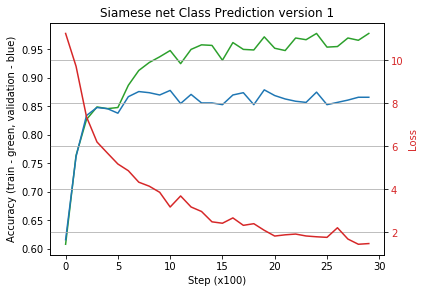

Siamese net version 2
Epoch 5/30, loss 6.0746, class train/test accuracy: 0.839/0.839 
Epoch 10/30, loss 4.6355, class train/test accuracy: 0.896/0.868 
Epoch 15/30, loss 3.7048, class train/test accuracy: 0.932/0.875 
Epoch 20/30, loss 3.2087, class train/test accuracy: 0.931/0.862 
Epoch 25/30, loss 3.0354, class train/test accuracy: 0.933/0.852 
Epoch 30/30, loss 2.3172, class train/test accuracy: 0.971/0.854 
Achieved accuracy: 0.88


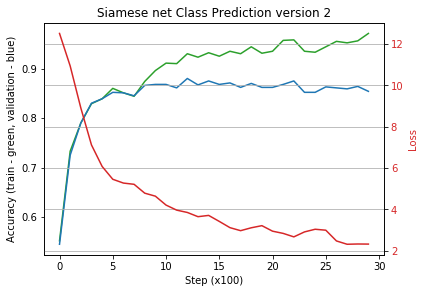

Siamese net version 3
Epoch 5/30, loss 5.1490, class train/test accuracy: 0.873/0.847 
Epoch 10/30, loss 2.9123, class train/test accuracy: 0.95/0.85 
Epoch 15/30, loss 1.7000, class train/test accuracy: 0.954/0.836 
Epoch 20/30, loss 1.5252, class train/test accuracy: 0.977/0.848 
Epoch 25/30, loss 0.5821, class train/test accuracy: 1.0/0.86 
Epoch 30/30, loss 0.4546, class train/test accuracy: 1.0/0.856 
Achieved accuracy: 0.86


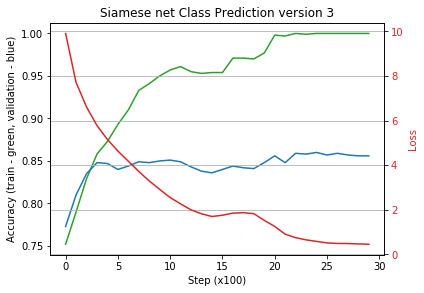

In [34]:
for ver in siamese_net_versions:
    print(f"Siamese net version {ver}")
    net_siamese = NetSiamese(input_channels, output_class_channels, output_digit_channels, activation="leakyrelu", version=ver)
    optimizer = optim.Adam(net_siamese.parameters(), lr=lr_siamese_net_all[ver], weight_decay=reg_siamese_net_all[ver])
    criterion = siamese_model_criterion

    _, accuracies, losses = train(train_loader, test_loader,
                                   net_siamese,
                                   optimizer, 
                                   criterion,
                                   device=device,
                                   epochs=epochs_train, print_info=True)

    accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit = accuracies
    
    plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, 
                           title=f"Siamese net Class Prediction version {ver}")

In [35]:
# siamese_net_filename = "net_siamese_loss.ckpt"
# torch.save(net_siamese.state_dict(), siamese_net_filename)

#### Auxiliary loss

In [36]:
epochs_grid_search = 25
epochs_train = 30

In [37]:
best_lambda = 1

In [38]:
model_class = NetSiamese
criterion = get_auxiliary_loss_model_criterion(lambda_=best_lambda)
lr_auxiliary_loss_all = dict()
reg_auxiliary_loss_all = dict()

for ver in siamese_net_versions:
    print(f"Siamese net version {ver}")
    model_params = {"input_channels": input_channels, 
                    "output_class_channels": output_class_channels, 
                    "output_digit_channels": output_digit_channels,
                    "activation": "leakyrelu",
                    "auxiliary_loss": True,
                    "version": ver}

    lr_auxiliary_loss, reg_auxiliary_loss = grid_search([0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], # Learning rates
                                                          [0.25, 0.1, 0.05, 0.01], # Regularizations
                                                          train, train_loader, test_loader, device, 
                                                          model_class, model_params, criterion, 
                                                          epochs=epochs_grid_search, print_info=True)
    
    lr_auxiliary_loss_all[ver] = lr_auxiliary_loss
    reg_auxiliary_loss_all[ver] = reg_auxiliary_loss

Siamese net version 1
Learning rate: 0.0500, Regularization: 0.25, Test Accuracy: 0.817
Learning rate: 0.0500, Regularization: 0.10, Test Accuracy: 0.847
Learning rate: 0.0500, Regularization: 0.05, Test Accuracy: 0.868
Learning rate: 0.0500, Regularization: 0.01, Test Accuracy: 0.888
Learning rate: 0.0100, Regularization: 0.25, Test Accuracy: 0.816
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.880
Learning rate: 0.0100, Regularization: 0.05, Test Accuracy: 0.874
Learning rate: 0.0100, Regularization: 0.01, Test Accuracy: 0.902
Learning rate: 0.0050, Regularization: 0.25, Test Accuracy: 0.811
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.874
Learning rate: 0.0050, Regularization: 0.05, Test Accuracy: 0.885
Learning rate: 0.0050, Regularization: 0.01, Test Accuracy: 0.895
Learning rate: 0.0010, Regularization: 0.25, Test Accuracy: 0.789
Learning rate: 0.0010, Regularization: 0.10, Test Accuracy: 0.855
Learning rate: 0.0010, Regularization: 0.05, Test Accu

Let's see the model's perfomance

Siamese net version 1
Epoch 5/30, loss 7.0880, class train/test accuracy: 0.9/0.861 , digit train/test accuracy: 0.9715/0.9415
Epoch 10/30, loss 4.6287, class train/test accuracy: 0.928/0.868 , digit train/test accuracy: 0.9835/0.9505
Epoch 15/30, loss 4.0564, class train/test accuracy: 0.944/0.867 , digit train/test accuracy: 0.9835/0.9505
Epoch 20/30, loss 3.2766, class train/test accuracy: 0.959/0.854 , digit train/test accuracy: 0.988/0.948
Epoch 25/30, loss 3.4238, class train/test accuracy: 0.941/0.841 , digit train/test accuracy: 0.975/0.924
Epoch 30/30, loss 1.9037, class train/test accuracy: 0.972/0.88 , digit train/test accuracy: 0.9895/0.946
Achieved accuracy: 0.887


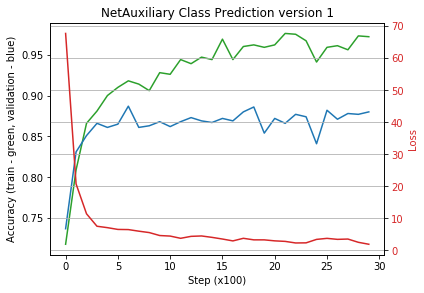

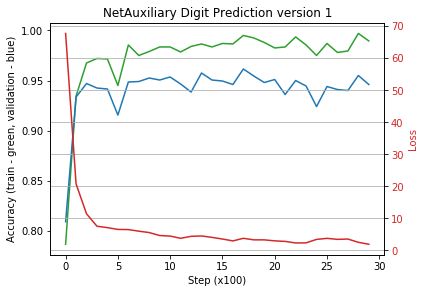

Siamese net version 2
Epoch 5/30, loss 12.6474, class train/test accuracy: 0.862/0.862 , digit train/test accuracy: 0.947/0.9345
Epoch 10/30, loss 8.5877, class train/test accuracy: 0.909/0.864 , digit train/test accuracy: 0.956/0.9405
Epoch 15/30, loss 8.3799, class train/test accuracy: 0.92/0.873 , digit train/test accuracy: 0.964/0.947
Epoch 20/30, loss 7.5772, class train/test accuracy: 0.909/0.864 , digit train/test accuracy: 0.975/0.95
Epoch 25/30, loss 7.3389, class train/test accuracy: 0.926/0.87 , digit train/test accuracy: 0.9835/0.95
Epoch 30/30, loss 7.1732, class train/test accuracy: 0.933/0.878 , digit train/test accuracy: 0.9825/0.9445
Achieved accuracy: 0.879


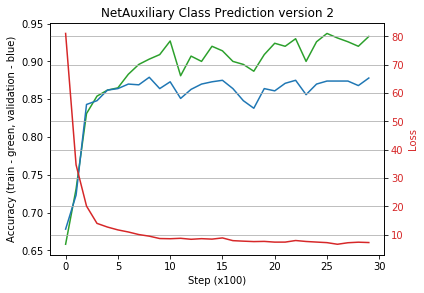

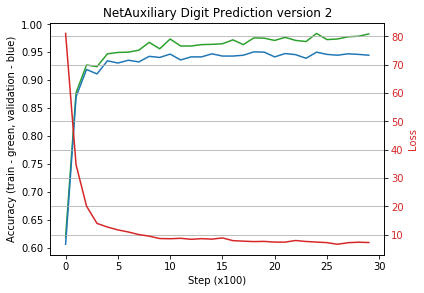

Siamese net version 3
Epoch 5/30, loss 17.9398, class train/test accuracy: 0.864/0.868 , digit train/test accuracy: 0.913/0.894
Epoch 10/30, loss 8.7602, class train/test accuracy: 0.9/0.863 , digit train/test accuracy: 0.9745/0.9375
Epoch 15/30, loss 8.1357, class train/test accuracy: 0.92/0.876 , digit train/test accuracy: 0.9625/0.9335
Epoch 20/30, loss 7.8785, class train/test accuracy: 0.93/0.894 , digit train/test accuracy: 0.956/0.9255
Epoch 25/30, loss 7.7370, class train/test accuracy: 0.914/0.882 , digit train/test accuracy: 0.9755/0.9275
Epoch 30/30, loss 7.7465, class train/test accuracy: 0.928/0.885 , digit train/test accuracy: 0.9695/0.934
Achieved accuracy: 0.894


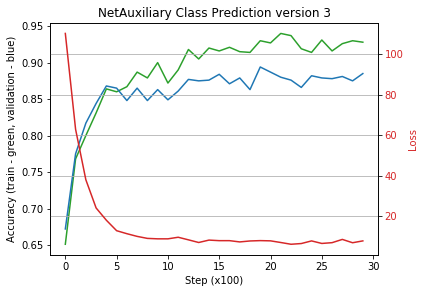

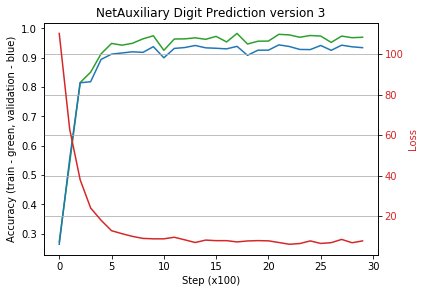

In [39]:
for ver in siamese_net_versions:
    print(f"Siamese net version {ver}")
    net_auxiliary_loss = NetSiamese(input_channels, output_class_channels, output_digit_channels, 
                                activation="leakyrelu", auxiliary_loss=True, version=ver)
    optimizer = optim.Adam(net_auxiliary_loss.parameters(), lr=lr_auxiliary_loss_all[ver], weight_decay=reg_auxiliary_loss_all[ver])
    criterion = get_auxiliary_loss_model_criterion(lambda_=best_lambda)

    _, accuracies, losses = train(train_loader, test_loader,
                                   net_auxiliary_loss,
                                   optimizer, 
                                   criterion,
                                   device=device,
                                   epochs=epochs_train, print_info=True)

    accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit = accuracies
    plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, 
                           title=f"NetAuxiliary Class Prediction version {ver}")
    plot_accuracy_and_loss(accuracy_train_digit, accuracy_test_digit, losses, 
                           title=f"NetAuxiliary Digit Prediction version {ver}")

In [40]:
# net_auxiliary_loss_filename = "net_auxiliary_loss.ckpt"
# torch.save(net_auxiliary_loss.state_dict(), net_auxiliary_loss_filename)

#### Digit prediction

In [41]:
epochs_grid_search = 25
epochs_train = 30

In [42]:
model_class = NetSiamese
model_params = {"input_channels": input_channels, 
                "output_class_channels": output_class_channels, 
                "output_digit_channels": output_digit_channels,
                "activation": "leakyrelu",
                "auxiliary_loss": True,
                "version": 4}
criterion = digit_prediction_criterion

lr_digit_prediction, reg_digit_prediction = grid_search([0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], # Learning rates
                                                      [0.25, 0.1, 0.05, 0.01], # Regularizations
                                                      train, train_loader, test_loader, device, 
                                                      model_class, model_params, criterion, 
                                                      epochs=epochs_grid_search, print_info=True)

lr_auxiliary_loss_all[4] = lr_digit_prediction
reg_auxiliary_loss_all[4] = reg_digit_prediction

Learning rate: 0.0500, Regularization: 0.25, Test Accuracy: 0.857
Learning rate: 0.0500, Regularization: 0.10, Test Accuracy: 0.944
Learning rate: 0.0500, Regularization: 0.05, Test Accuracy: 0.967
Learning rate: 0.0500, Regularization: 0.01, Test Accuracy: 0.972
Learning rate: 0.0100, Regularization: 0.25, Test Accuracy: 0.912
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.974
Learning rate: 0.0100, Regularization: 0.05, Test Accuracy: 0.970
Learning rate: 0.0100, Regularization: 0.01, Test Accuracy: 0.977
Learning rate: 0.0050, Regularization: 0.25, Test Accuracy: 0.920
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.961
Learning rate: 0.0050, Regularization: 0.05, Test Accuracy: 0.969
Learning rate: 0.0050, Regularization: 0.01, Test Accuracy: 0.975
Learning rate: 0.0010, Regularization: 0.25, Test Accuracy: 0.922
Learning rate: 0.0010, Regularization: 0.10, Test Accuracy: 0.953
Learning rate: 0.0010, Regularization: 0.05, Test Accuracy: 0.962
Learning r

Let's see the model's perfomance

In [43]:
net_digit_prediction = NetSiamese(input_channels, output_class_channels, output_digit_channels, 
                                activation="leakyrelu", auxiliary_loss=True, version=4)
optimizer = optim.Adam(net_digit_prediction.parameters(), lr=lr_digit_prediction, weight_decay=reg_digit_prediction)
criterion = digit_prediction_criterion

net_digit_prediction, accuracies, losses = train(train_loader, test_loader,
                                                   net_digit_prediction,
                                                   optimizer, 
                                                   criterion,
                                                   device=device,
                                                   epochs=epochs_train, print_info=True)

accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit = accuracies

Epoch 5/30, loss 2.5323, class train/test accuracy: 0.987/0.964 , digit train/test accuracy: 0.9725/0.95
Epoch 10/30, loss 1.5432, class train/test accuracy: 0.996/0.966 , digit train/test accuracy: 0.986/0.9555
Epoch 15/30, loss 2.3946, class train/test accuracy: 0.98/0.96 , digit train/test accuracy: 0.9765/0.935
Epoch 20/30, loss 1.6645, class train/test accuracy: 0.988/0.965 , digit train/test accuracy: 0.9815/0.947
Epoch 25/30, loss 1.2084, class train/test accuracy: 0.998/0.974 , digit train/test accuracy: 0.996/0.96
Epoch 30/30, loss 1.2992, class train/test accuracy: 0.997/0.973 , digit train/test accuracy: 0.992/0.957
Achieved accuracy: 0.975


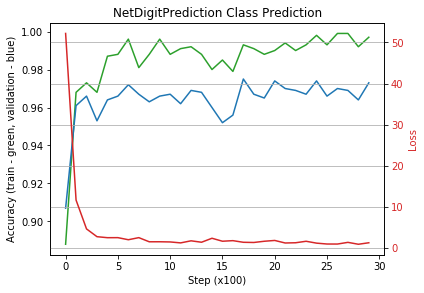

In [44]:
plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, title="NetDigitPrediction Class Prediction")

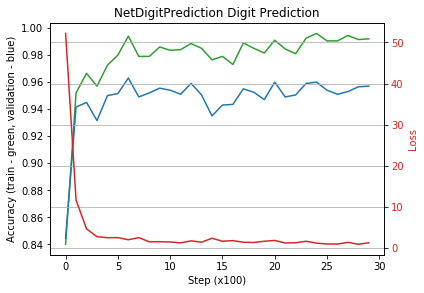

In [45]:
plot_accuracy_and_loss(accuracy_train_digit, accuracy_test_digit, losses, title="NetDigitPrediction Digit Prediction")

### Observations

From these plots we can derive several observations:
* Siamese network with auxiliary loss overfits less than Simple and Siamese models. Thus we can say that auxiliary loss perfoms like additional regulariser.
* Siamese network of version 4 is overfitting less than other models. That may mean that overfitting in siamese networks is caused by last layers responsible for predicting class from digit's encodings.
* Siamese models' capacity is enough for getting accuracy of level approximately 95% (version 4 reached 97%). We can use this result as benchmark for another versions of Siamese model. Also, we don't need to add more capacity to siamese network.

### Test

#### Simple net

In [46]:
# checkpoint = torch.load(net_simple_filename)
# net_simple = NetSimple(input_channels, output_class_channels)
# net_simple.load_state_dict(checkpoint)
# # net_simple.to(device)

In [47]:
# test_samples(net_simple, test_input, test_class, test_digit)

#### Weight sharing (Siamese network)

In [48]:
# checkpoint = torch.load(siamese_net_filename)
# net_siamese = NetSiamese(input_channels, output_class_channels, output_digit_channels)
# net_siamese.load_state_dict(checkpoint)
# # net_simple.to(device)

In [49]:
# test_samples(net_siamese, test_input, test_class, test_digit)

#### Auxiliary loss

In [50]:
# checkpoint = torch.load(net_auxiliary_loss_filename)
# net_auxiliary_loss = NetSiamese(input_channels, output_class_channels, output_digit_channels, auxiliary_loss=True)
# net_auxiliary_loss.load_state_dict(checkpoint)
# # net_simple.to(device)

In [51]:
# test_samples(net_auxiliary_loss, test_input, test_class, test_digit)

## Models' assessment

Let's estimate average perfomance through 10+ rounds for each architecture, where both data and weight initialization are randomized

In [53]:
nb_tests = 20
epochs_train = 40
N = 1000

#### Simple net

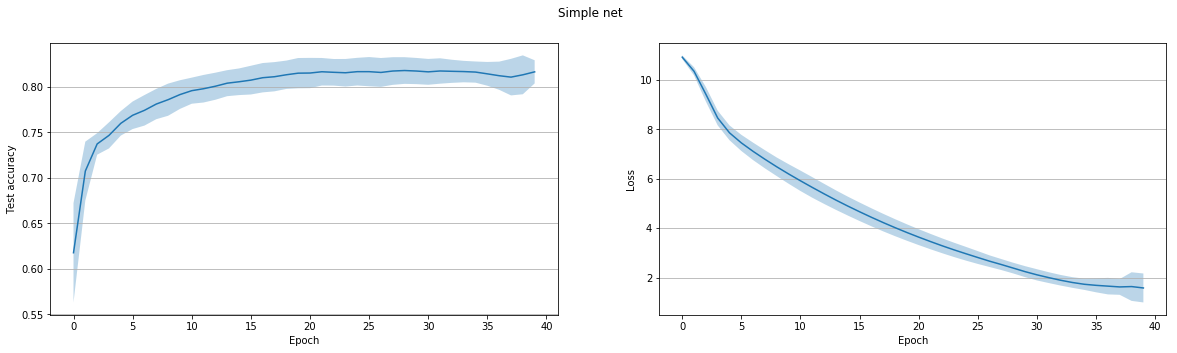

Best mean accuracy was 0.824.


In [54]:
model_class = NetSimple
model_params = {"input_channels": input_channels, 
                "output_channels": output_class_channels,
                "activation": "leakyrelu"}
criterion = simple_model_criterion

accuracy_values, loss_values = test_model(train, generate_data, device,
                                          model_class, model_params, criterion, 
                                          lr_simple_net, reg_simple_net,
                                          nb_tests=nb_tests, epochs=epochs_train)

plot_test_results(accuracy_values, loss_values, title="Simple net")
print(f"Best mean accuracy was {np.mean(np.max(accuracy_values, axis=1)):0.3f}.")

#### Siamese Net 

Let's try different versions of siamese network

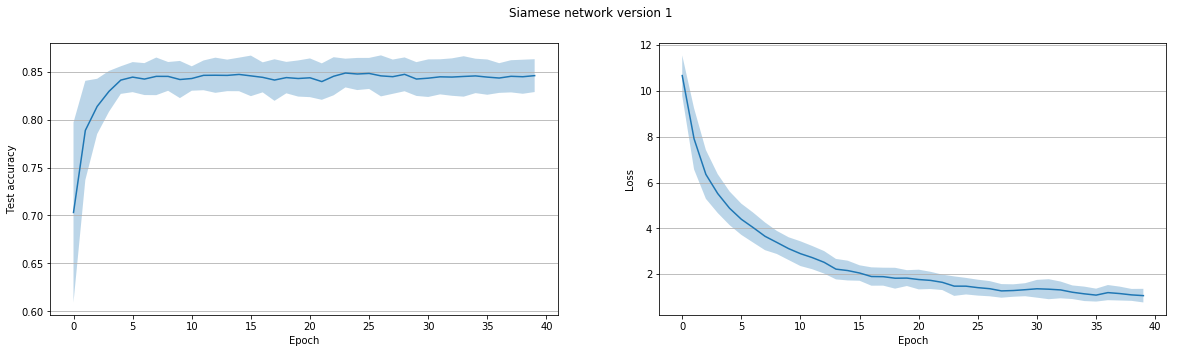

Best mean accuracy was 0.864.


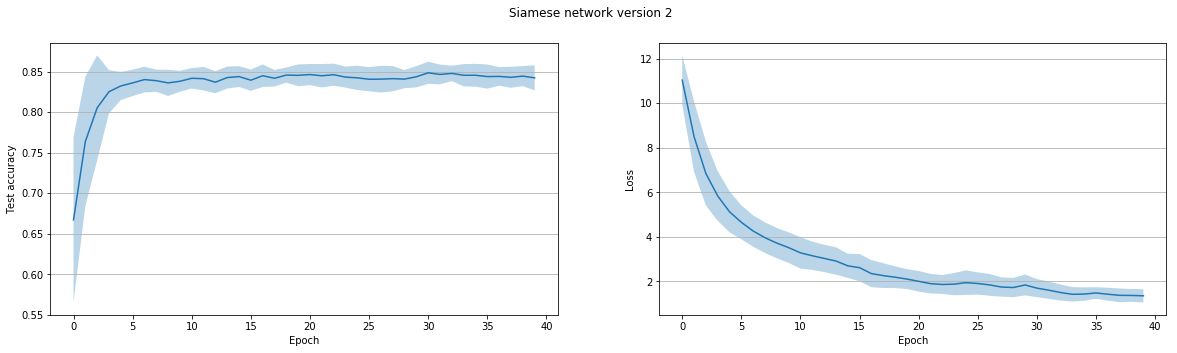

Best mean accuracy was 0.861.


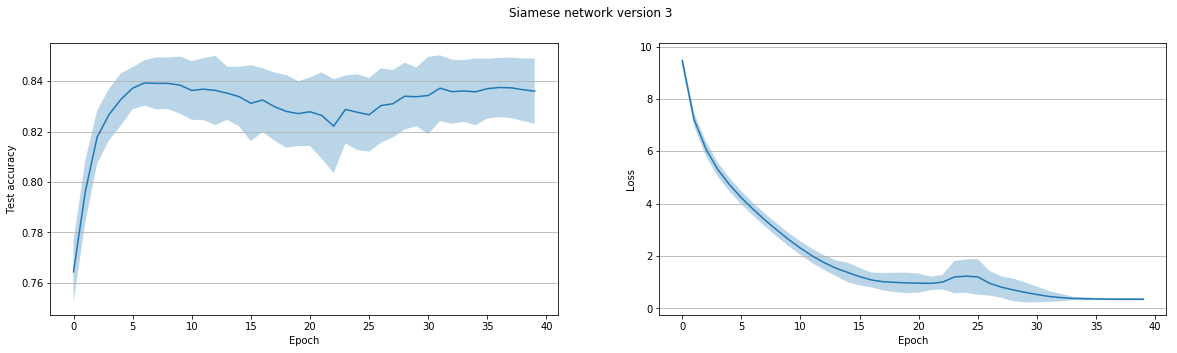

Best mean accuracy was 0.846.


In [55]:
for ver in siamese_net_versions: 
    model_class = NetSiamese
    model_params = {"input_channels": input_channels, 
                    "output_class_channels": output_class_channels, 
                    "output_digit_channels": output_digit_channels,
                    "activation": "leakyrelu",
                    "version": ver}
    criterion = siamese_model_criterion
    
    accuracy_values, loss_values = test_model(train, generate_data, device,
                                              model_class, model_params, criterion, 
                                              lr_siamese_net_all[ver], reg_siamese_net_all[ver],
                                              nb_tests=nb_tests, epochs=epochs_train)
    
    plot_test_results(accuracy_values, loss_values, title=f"Siamese network version {ver}")
    print(f"Best mean accuracy was {np.mean(np.max(accuracy_values, axis=1)):0.3f}.")

#### Net with AuxiliaryLoss

Let's try different versions of siamese network

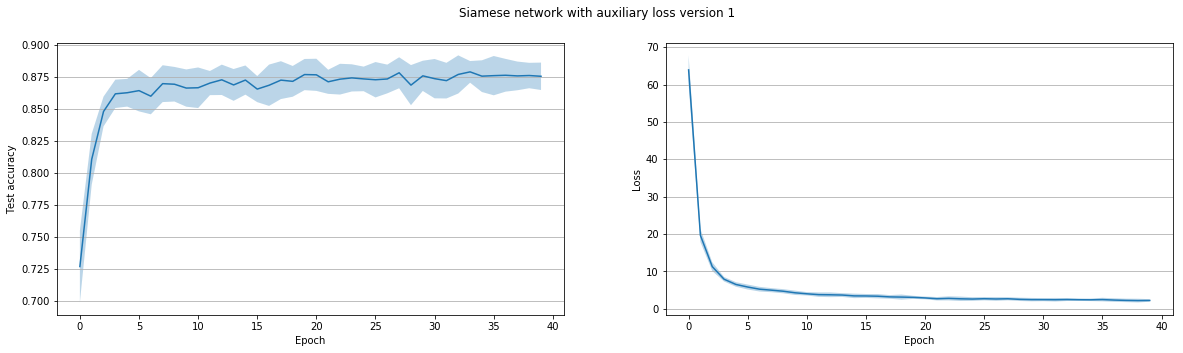

Best mean accuracy was 0.893.


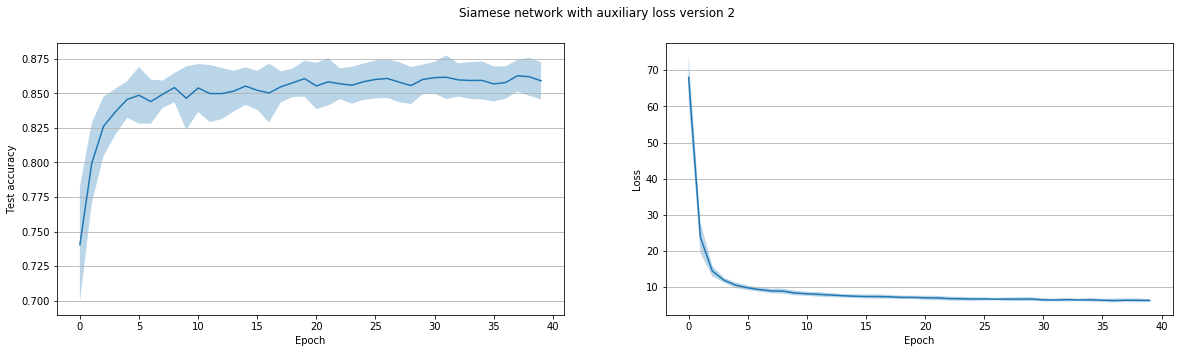

Best mean accuracy was 0.877.


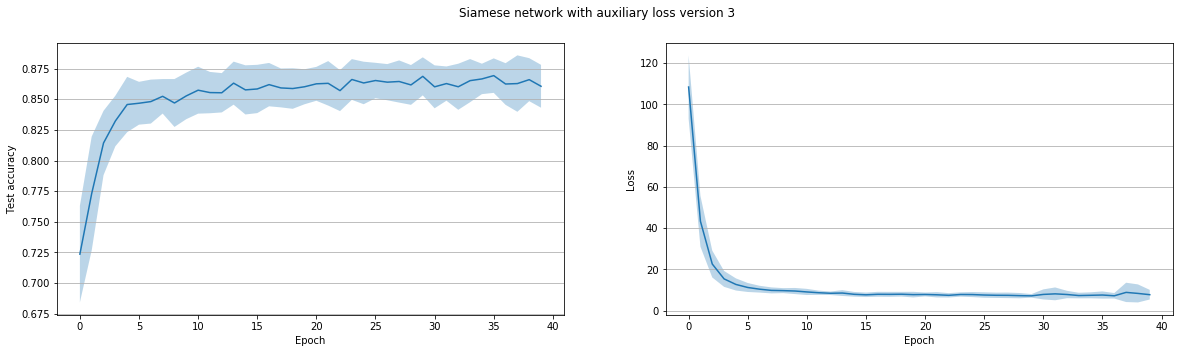

Best mean accuracy was 0.886.


In [56]:
for ver in siamese_net_versions:
    model_class = NetSiamese
    model_params = {"input_channels": input_channels, 
                    "output_class_channels": output_class_channels, 
                    "output_digit_channels": output_digit_channels,
                    "activation": "leakyrelu",
                    "version": ver,
                    "auxiliary_loss": True}
    criterion = get_auxiliary_loss_model_criterion(lambda_=best_lambda)

    accuracy_values, loss_values = test_model(train, generate_data, device,
                                              model_class, model_params, criterion, 
                                              lr_auxiliary_loss_all[ver], reg_auxiliary_loss_all[ver],
                                              nb_tests=nb_tests, epochs=epochs_train)
    
    plot_test_results(accuracy_values, loss_values, title=f"Siamese network with auxiliary loss version {ver}")
    print(f"Best mean accuracy was {np.mean(np.max(accuracy_values, axis=1)):0.3f}.")

We see that simple net model have accuracy below 82%. Then, turning to siamese arhitecture we increase accuracy to level 86%. Finnaly, after adding additional loss for sample's both digit prediction we got accuracy approximately 89%.

#### Net for digit prediction

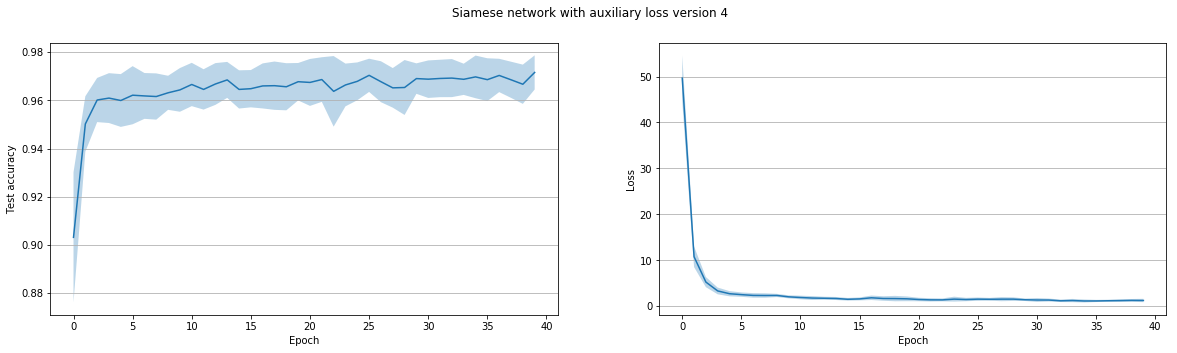

Best mean accuracy was 0.978.


In [57]:
model_class = NetSiamese
model_params = {"input_channels": input_channels, 
                "output_class_channels": output_class_channels, 
                "output_digit_channels": output_digit_channels,
                "activation": "leakyrelu",
                "version": 4,
                "auxiliary_loss": True}
criterion = digit_prediction_criterion

accuracy_values, loss_values = test_model(train, generate_data, device,
                                            model_class, model_params, criterion, lr_digit_prediction, reg_digit_prediction,
                                            nb_tests=nb_tests, epochs=epochs_train)

plot_test_results(accuracy_values, loss_values, title=f"Siamese network with auxiliary loss version {4}")
print(f"Best mean accuracy was {np.mean(np.max(accuracy_values, axis=1)):0.3f}.")

This type of network achieves best result, namely 97% accuracy.

#### Oversampling or Undersampling

Let's try apply dataset balancing technique for best model to see wheither we can improve obtained results.

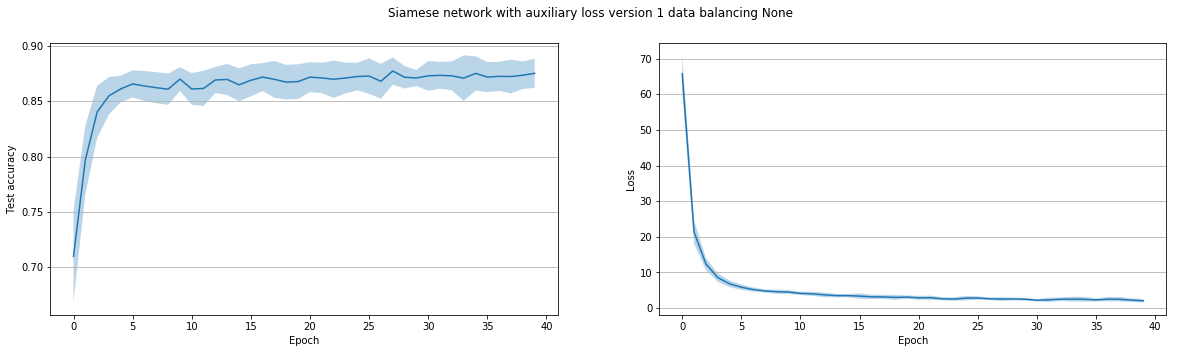

Best mean accuracy was 0.891.


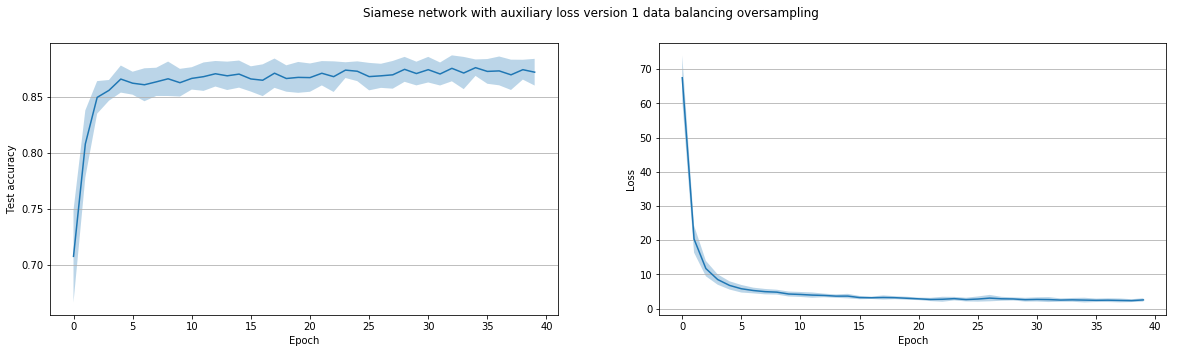

Best mean accuracy was 0.890.


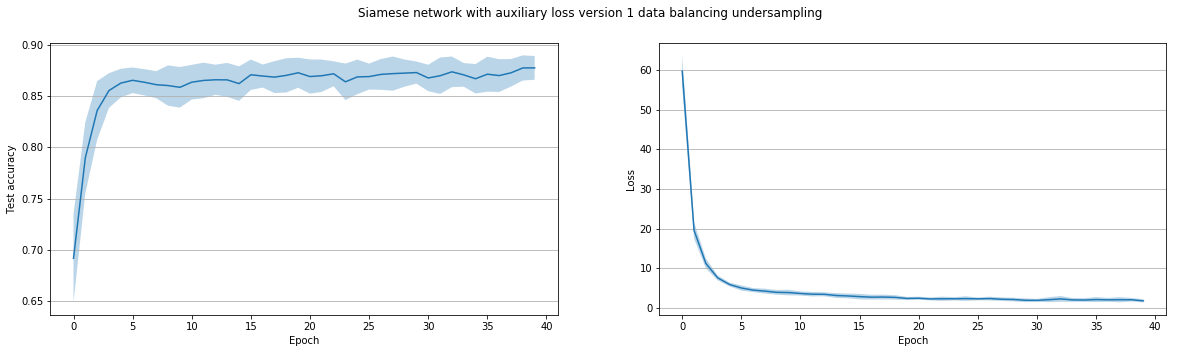

Best mean accuracy was 0.890.


In [58]:
data_modes = [None, "oversampling", "undersampling"]

for mode in data_modes:
    ver = 1
    model_class = NetSiamese
    model_params = {"input_channels": input_channels, 
                    "output_class_channels": output_class_channels, 
                    "output_digit_channels": output_digit_channels,
                    "activation": "leakyrelu",
                    "version": ver,
                    "auxiliary_loss": True}
    criterion = get_auxiliary_loss_model_criterion(lambda_=best_lambda)

    accuracy_values, loss_values = test_model(train, generate_data, device,
                                              model_class, model_params, criterion, 
                                              lr_auxiliary_loss_all[ver], reg_auxiliary_loss_all[ver],
                                              nb_tests=nb_tests, epochs=epochs_train, generate_data_mode=mode)
    
    plot_test_results(accuracy_values, loss_values, 
                      title=f"Siamese network with auxiliary loss version {ver} data balancing {mode}")
    print(f"Best mean accuracy was {np.mean(np.max(accuracy_values, axis=1)):0.3f}.")

As we can see class balancing techniques does not improve the accuracy. Mainly this is due to the fact that classes initially are not much imbalanced 

### Investigation

We see drop of accuracy when we switch from Siamese model version 4 to version 1 although the latter has only one extra layer which aims to predict class labels instead of simple comparison operation in the former.

Let's train Siamese model version 1 and visualise weights of it's last fully connected layer

In [59]:
# Backup
if not ('lr_auxiliary_loss_all' in vars() or 'lr_auxiliary_loss_all' in globals()): 
    lr_auxiliary_loss_all = {1: 0.01, 2: 0.01, 3: 0.005}
    reg_auxiliary_loss_all = {1: 0.01, 2: 0.05, 3: 0.01}

In [73]:
ver = 1
net_auxiliary_loss = NetSiamese(input_channels, output_class_channels, output_digit_channels, 
                            activation="leakyrelu", auxiliary_loss=True, version=ver)
optimizer = optim.Adam(net_auxiliary_loss.parameters(), lr=lr_auxiliary_loss_all[ver], weight_decay=reg_auxiliary_loss_all[ver])
criterion = get_auxiliary_loss_model_criterion(lambda_=best_lambda)

net_auxiliary_loss, accuracies, losses = train(train_loader, test_loader,
                                               net_auxiliary_loss,
                                               optimizer, 
                                               criterion,
                                               device=device,
                                               epochs=epochs_train, print_info=True)

Epoch 5/40, loss 6.4380, class train/test accuracy: 0.913/0.873 , digit train/test accuracy: 0.978/0.9495
Epoch 10/40, loss 4.1113, class train/test accuracy: 0.944/0.876 , digit train/test accuracy: 0.989/0.954
Epoch 15/40, loss 4.2058, class train/test accuracy: 0.954/0.878 , digit train/test accuracy: 0.974/0.945
Epoch 20/40, loss 2.3231, class train/test accuracy: 0.976/0.885 , digit train/test accuracy: 0.99/0.9525
Epoch 25/40, loss 2.4491, class train/test accuracy: 0.984/0.904 , digit train/test accuracy: 0.987/0.9505
Epoch 30/40, loss 3.4272, class train/test accuracy: 0.969/0.885 , digit train/test accuracy: 0.9935/0.958
Epoch 35/40, loss 3.5852, class train/test accuracy: 0.968/0.892 , digit train/test accuracy: 0.9925/0.956
Epoch 40/40, loss 1.8093, class train/test accuracy: 0.99/0.892 , digit train/test accuracy: 0.986/0.9375
Achieved accuracy: 0.904


In [74]:
weights = net_auxiliary_loss.fc3.weight.data.cpu().numpy()

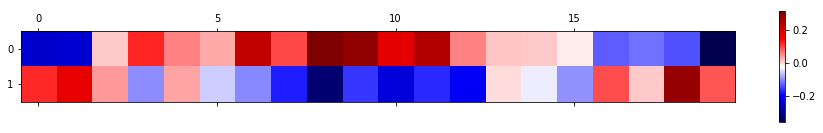

In [75]:
plt.matshow(weights, cmap='seismic')
plt.colorbar()
plt.show()

Let's now see how these weights process different inputs.

In [76]:
major_value = 0.8
minor_value = (1 - major_value) / (10 - 1)

def build_input(major_digit1_ind, major_digit2_ind):
    x = [minor_value] * 20 
    x[major_digit1_ind] = major_value
    x[10 + major_digit2_ind] = major_value
    
    return torch.tensor(x).unsqueeze(0) 

In [77]:
predictions = np.zeros((10, 10))
target = np.zeros((10, 10))

for major_digit1_ind in range(10):
    for major_digit2_ind in range(10):
        x = build_input(major_digit1_ind, major_digit2_ind)
        _, prediction = torch.max(x @ weights.T, 1)
        predictions[major_digit1_ind, major_digit2_ind] = prediction.item()
        target[major_digit1_ind, major_digit2_ind] = major_digit1_ind <= major_digit2_ind

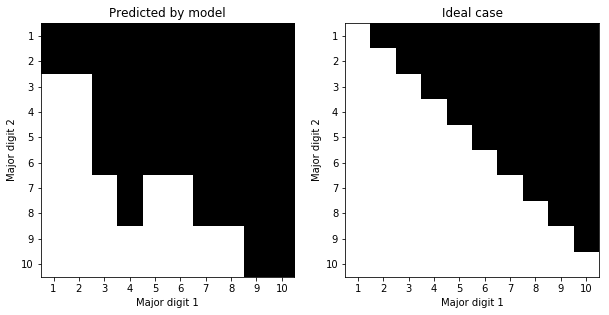

In [78]:
# Predictions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(predictions.T, cmap='gray')
plt.xticks(range(10), [i for i in range(1, 11)])
plt.yticks(range(10), [i for i in range(1, 11)])
plt.xlabel("Major digit 1")
plt.ylabel("Major digit 2")
plt.title("Predicted by model")

# Target
plt.subplot(1, 2, 2)
plt.imshow(target.T, cmap='gray')
plt.xticks(range(10), [i for i in range(1, 11)])
plt.yticks(range(10), [i for i in range(1, 11)])
plt.xlabel("Major digit 1")
plt.ylabel("Major digit 2")
plt.title("Ideal case")

plt.show()

On plot above white cells represent cases when model outputs class 1 which means that model thinks that digit 1 is less or equal to digit2. Black cells means opposite class.

Ideally, plot should be full white (class 1) in the lower left and full black (class 0) in the upper right part. Looking at the real values of this matrix we can see that it is far from ideal one which means that weights are not learned perfectly and model fails to predict whether first digit is less or equal than second even if it knows value of both digits.

In [79]:
print(f"Errors in {np.count_nonzero(predictions != target)}% cases")

Errors in 21% cases


#### Improvement

To improve the results we tried to force model to detect the digit with biggest probability. For that we applied softmax to vectors of digit probabilities predictions (Siamese model version 5). Beside that we also made another version (version 6) where we added one extra fully connected layer which may learn to do something equivalent to softmax on its own.

In [80]:
# Grid search for hyperparameters for new models
model_class = NetSiamese
criterion = get_auxiliary_loss_model_criterion(lambda_=best_lambda)

for ver in [5, 6]:
    print(f"Siamese net version {ver}")
    model_params = {"input_channels": input_channels, 
                    "output_class_channels": output_class_channels, 
                    "output_digit_channels": output_digit_channels,
                    "activation": "leakyrelu",
                    "auxiliary_loss": True,
                    "version": ver}

    lr_auxiliary_loss, reg_auxiliary_loss = grid_search([0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], # Learning rates
                                                          [0.25, 0.1, 0.05, 0.01], # Regularizations
                                                          train, train_loader, test_loader, device, 
                                                          model_class, model_params, criterion, 
                                                          epochs=epochs_grid_search, print_info=True)
    
    lr_auxiliary_loss_all[ver] = lr_auxiliary_loss
    reg_auxiliary_loss_all[ver] = reg_auxiliary_loss

Siamese net version 5
Learning rate: 0.0500, Regularization: 0.25, Test Accuracy: 0.768
Learning rate: 0.0500, Regularization: 0.10, Test Accuracy: 0.874
Learning rate: 0.0500, Regularization: 0.05, Test Accuracy: 0.921
Learning rate: 0.0500, Regularization: 0.01, Test Accuracy: 0.947
Learning rate: 0.0100, Regularization: 0.25, Test Accuracy: 0.739
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.878
Learning rate: 0.0100, Regularization: 0.05, Test Accuracy: 0.923
Learning rate: 0.0100, Regularization: 0.01, Test Accuracy: 0.944
Learning rate: 0.0050, Regularization: 0.25, Test Accuracy: 0.737
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.876
Learning rate: 0.0050, Regularization: 0.05, Test Accuracy: 0.931
Learning rate: 0.0050, Regularization: 0.01, Test Accuracy: 0.948
Learning rate: 0.0010, Regularization: 0.25, Test Accuracy: 0.726
Learning rate: 0.0010, Regularization: 0.10, Test Accuracy: 0.854
Learning rate: 0.0010, Regularization: 0.05, Test Accu

In [81]:
# Train models
models = {}

for ver in [1, 5, 6]:
    print(f"Siamese net version {ver}")
    net_auxiliary_loss = NetSiamese(input_channels, output_class_channels, output_digit_channels, 
                                activation="leakyrelu", auxiliary_loss=True, version=ver)
    optimizer = optim.Adam(net_auxiliary_loss.parameters(), lr=lr_auxiliary_loss_all[ver], weight_decay=reg_auxiliary_loss_all[ver])
    criterion = get_auxiliary_loss_model_criterion(lambda_=best_lambda)

    net_auxiliary_loss, accuracies, losses = train(train_loader, test_loader,
                                                   net_auxiliary_loss,
                                                   optimizer, 
                                                   criterion,
                                                   device=device,
                                                   epochs=epochs_train, print_info=True)
    models[ver] = net_auxiliary_loss

Siamese net version 1
Epoch 5/40, loss 6.1578, class train/test accuracy: 0.893/0.859 , digit train/test accuracy: 0.978/0.9485
Epoch 10/40, loss 4.5347, class train/test accuracy: 0.94/0.878 , digit train/test accuracy: 0.975/0.944
Epoch 15/40, loss 4.0875, class train/test accuracy: 0.945/0.873 , digit train/test accuracy: 0.989/0.9525
Epoch 20/40, loss 2.7884, class train/test accuracy: 0.983/0.896 , digit train/test accuracy: 0.994/0.964
Epoch 25/40, loss 3.6129, class train/test accuracy: 0.966/0.879 , digit train/test accuracy: 0.9815/0.942
Epoch 30/40, loss 1.8410, class train/test accuracy: 0.973/0.89 , digit train/test accuracy: 0.9935/0.9555
Epoch 35/40, loss 1.8701, class train/test accuracy: 0.978/0.898 , digit train/test accuracy: 0.9955/0.96
Epoch 40/40, loss 2.7010, class train/test accuracy: 0.968/0.884 , digit train/test accuracy: 0.996/0.9615
Achieved accuracy: 0.904
Siamese net version 5
Epoch 5/40, loss 10.8391, class train/test accuracy: 0.859/0.849 , digit train/t

In [82]:
model_predictions = []

for ver in [1, 5, 6]:
    model = models[ver]
    if ver == 6:
        weigths = [model.fc3.weight.data.cpu().numpy(), model.fc4.weight.data.cpu().numpy()]
    else:
        weights = [model.fc3.weight.data.cpu().numpy()]
        
    predictions = np.zeros((10, 10))
    
    for major_digit1_ind in range(10):
        for major_digit2_ind in range(10):
            x = build_input(major_digit1_ind, major_digit2_ind)
            for w in weights:
                x = x @ w.T
            _, prediction = torch.max(x, 1)
            predictions[major_digit1_ind, major_digit2_ind] = prediction.item()
            
    model_predictions.append(predictions)

In [83]:
target = np.tri(10, 10, 0).T

# Similar to:

# target = np.zeros((10, 10))
# for major_digit1_ind in range(10):
#     for major_digit2_ind in range(10):
#         target[major_digit1_ind, major_digit2_ind] = major_digit1_ind <= major_digit2_ind

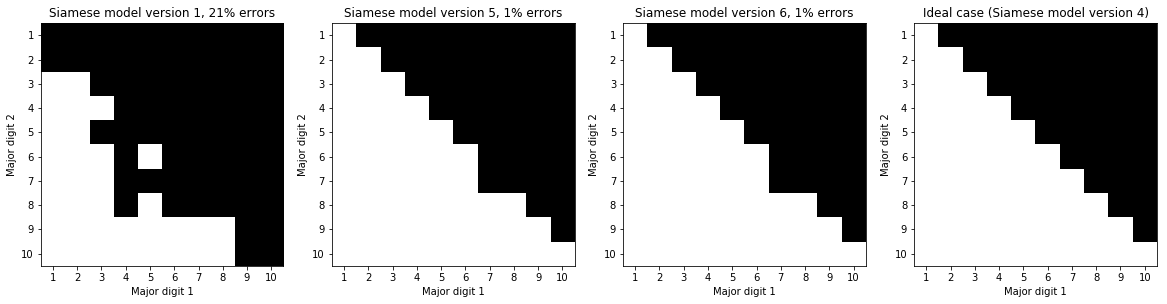

In [84]:
# Draw new results
titles = [f"Siamese model version 1", 
          f"Siamese model version 5", 
          f"Siamese model version 6", 
          f"Ideal case (Siamese model version 4)"]
predictions_to_draw = model_predictions + [target]

plt.figure(figsize=(20, 5))
for i, predictions in enumerate(predictions_to_draw):
    plt.subplot(1, len(predictions_to_draw), i + 1)
    plt.imshow(predictions.T, cmap='gray')
    plt.xticks(range(10), [i for i in range(1, 11)])
    plt.yticks(range(10), [i for i in range(1, 11)])
    plt.xlabel("Major digit 1")
    plt.ylabel("Major digit 2")
    title = titles[i]
    if predictions is not target: # We don't need errors number estimate for target predictions
        title += f", {np.count_nonzero(predictions != target)}% errors"
    plt.title(title)

Looks like new versions perfom way better than previous one. Let's estimate robustness of new model with 10+ rounds

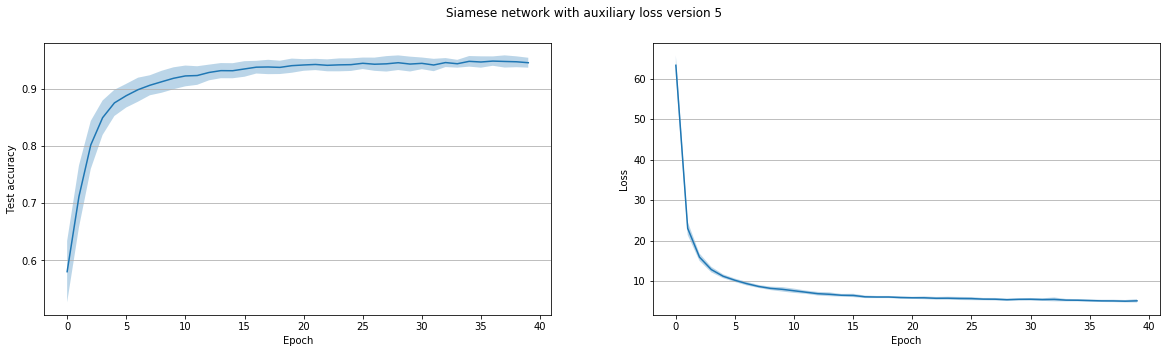

Best mean accuracy was 0.955.


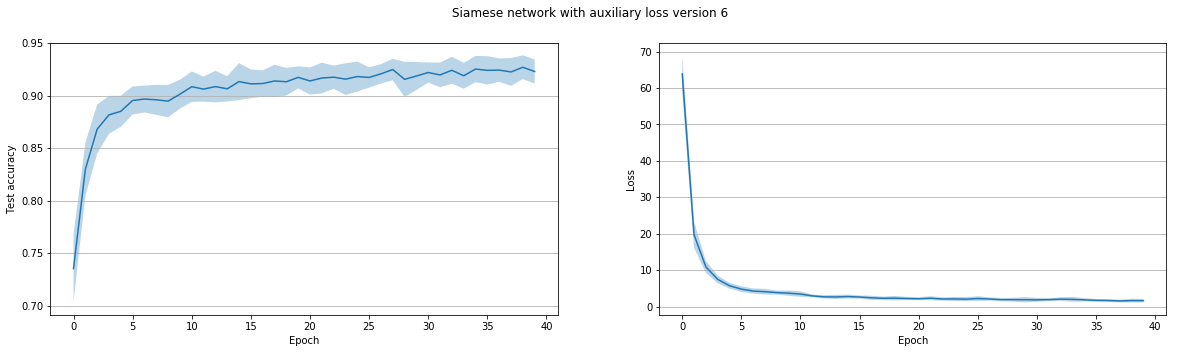

Best mean accuracy was 0.937.


In [86]:
for ver in [5, 6]:
    model_class = NetSiamese
    model_params = {"input_channels": input_channels, 
                    "output_class_channels": output_class_channels, 
                    "output_digit_channels": output_digit_channels,
                    "activation": "leakyrelu",
                    "version": ver,
                    "auxiliary_loss": True}
    criterion = get_auxiliary_loss_model_criterion(lambda_=best_lambda)

    accuracy_values, loss_values = test_model(train, generate_data, device,
                                              model_class, model_params, criterion, 
                                              lr_auxiliary_loss_all[ver], reg_auxiliary_loss_all[ver],
                                              nb_tests=nb_tests, epochs=epochs_train)
    
    plot_test_results(accuracy_values, loss_values, title=f"Siamese network with auxiliary loss version {ver}")
    print(f"Best mean accuracy was {np.mean(np.max(accuracy_values, axis=1)):0.3f}.")

Great, we see that now model version 5 and 6 reached better accuracy than previous models.

### Results

We developed 6 different versions of Siamese model with auxiliary loss, let's compare them:

In [97]:
data = [[1, "Predicts class from digit's predictions using 1 fully connected layer", 89.3],
        [2, "Predicts class from concatenated encodings of digits", 87.7],
        [3, "Predicts class from subtracted encodings of digits", 88.6],
        [4, "Predicts class simply by comparing digit's predictions (no use of any trainable layers)", 97.8],
        [5, "Predicts class from digit's prediction followed by softmax layer", 95.5],
        [6, "Predicts class from digit's predictions using 2 fully connected layers", 93.7]]

results = pd.DataFrame(data, columns=["Model's version", "Model's description", "Model's perfomance"])

In [98]:
results = results.sort_values("Model's perfomance", ascending=False)

In [115]:
pd.set_option('max_colwidth', 100)

In [118]:
print(results.to_string(index=False, justify="center"))

Model's version                                   Model's description                                     Model's perfomance
       4         Predicts class simply by comparing digit's predictions (no use of any trainable layers)         97.8       
       5                                Predicts class from digit's prediction followed by softmax layer         95.5       
       6                          Predicts class from digit's predictions using 2 fully connected layers         93.7       
       1                           Predicts class from digit's predictions using 1 fully connected layer         89.3       
       3                                              Predicts class from subtracted encodings of digits         88.6       
       2                                            Predicts class from concatenated encodings of digits         87.7


### Model's visualisation

In [ ]:
# !pip install graphviz

In [ ]:
from graphviz import Digraph
import torch
from torch.autograd import Variable

In [ ]:
def make_dot(var, params):
    """ Produces Graphviz representation of PyTorch autograd graph
    
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    param_map = {id(v): k for k, v in params.items()}
    print(param_map)
    
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()
    
    def size_to_str(size):
        return '('+(', ').join(['%d'% v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                node_name = '%s\n %s' % (param_map.get(id(u)), size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

In [ ]:
# import os
# os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38/bin/'

In [ ]:
plot_model_architecture = False

In [ ]:
if plot_model_architecture:
    filename = "Simple net"

    inputs = torch.randn(1, 2, 14, 14)
    y = net_simple(Variable(inputs))
    # g = make_dot(y, net_simple.state_dict())
    g = make_dot(y, params=dict(net_simple.named_parameters()))
    g.view(filename)

In [ ]:
if plot_model_architecture:
    ver = 2
    filename = f"Siamese version {ver}"
    net_siamese = NetSiamese(input_channels, output_class_channels, output_digit_channels, activation="leakyrelu", version=ver)

    inputs = torch.randn(1, 2, 14, 14)
    y = net_siamese(Variable(inputs))
    # g = make_dot(y, net_simple.state_dict())
    g = make_dot(y, params=dict(net_siamese.named_parameters()))
    g.view(filename)